# Implementing your own DIY neural network

_written by [Gene Kogan](https://www.genekogan.com)_

-----

Neural networks are the primary method that we will use for most of the rest of these guides. It is useful to understand how neural nets work, rather than looking at them like a black box. The best way to start is to code your own neural net, before graduating to the higher level frameworks that do it for you.

In this guide, we will derive and implement a simple 2-layer neural network with a sigmoid activation function. We will do so by starting with the linear regression example from the previous guide, and building on top of it. 

If you want more details about the theory, design, history, and applications of neural networks, look at the following resources:
* [ml4a chapter on neural networks](http://ml4a.github.io/ml4a/neural_networks/)
* Michael Nielsen's [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)
* Goodfellow, Bengio, and Courville's [Deep Learning](http://www.deeplearningbook.org/) book
* [Francis Tseng's AI notes](http://frnsys.com/ai_notes/machine_learning/neural_nets.html) on neural networks.


# Review of linear regression

Let's quickly recall our linear regression example from the last notebook.

Suppose we have a set of points $(X, Y)$, and we'd like to find a line, $y=mx+b$ which best fits that dataset. We would like to find the parameters, $m$ and $b$ which minimize the sum squared error, $J = \frac{1}{2} \sum_i{(y_i - (mx_i + b))^2}$. Although there exists a quicker analytical way of solving a linear regression, we instead introduced gradient descent as a way of solving a linear regression.  

With gradient descent, we calculate the gradient of the loss function $J$ with respect to the parameters $m$ and $b$. 

$$
\nabla J = \left[ \frac{\partial J}{\partial m}, \frac{\partial J}{\partial b} \right] = \left[ -\sum_i{x_i \cdot (y_i - (mx_i + b))}, -\sum_i{(y_i - (mx_i + b))} \right]
$$

And then we picked a random initial $m$ and $b$, and then defined an update rule where we calculate the gradient and then adjust the parameters $m$ and $b$ with the following formula:

$$ m := m - \alpha \cdot \frac{\partial J}{\partial m} $$
$$ b := b - \alpha \cdot \frac{\partial J}{\partial b} $$

We do this some number of times, and $m$ and $b$ converge to the optimal solution.

# Introducing neural networks

We are now going to innovate our linear regression in a few ways and turn it into a multiple-layer neural network.

A neural network is a data structure made up of "_neurons_" connected to each other in a directed graph. Each neuron has a value, often called its "_activation_" or "_activity_," which is computed as a function of the sum of the activations which go into it. It then, in turn, passes its activation on to the next neurons. 

Here is an example.

![neural net](../../assets/neuralnet.jpg)

Generally, neurons are organized into layers, and each layer connects and forwards its activations to the next layer. The most basic architecture for a layer is a "fully-connected" (or "dense") layer, in which every neuron is connected to every neuron of the previous layer. The first layer of the network is the "input," which is where the input vector first goes, and the last layer is the "output."

## Weights

The connections between neurons are regulated by "_weights_" or "_parameters_." Activations are multiplied by weights as they go to the next layer, thereby scaling up or down their influence. 

**todo: book references**

The inner operations of the basic unit is straightforward. We collapse the weight vector $w$ and input vector $v$ into a scalar by taking their dot product. Often a "_bias_" term $b$ is added to this dot product; this bias is also learned, just like the weights are learned. 

Finally, the dot product is passed through an "_activation function_" $f$, which also returns a scalar. Activation functions are typically nonlinear so that neural networks can learn nonlinear functions. Although this increases the complexity of neural network and reduces our ability to work with them analytically, it greatly increases the network's flexibility and modeling power. 

We'll mention a few different activation functions in a bit, but for now let's see what a single neuron is doing:









First, let's start by adding another input variable, so that now our input is two dimensions. We'll go back to the Iris dataset, and pose the following problem: given the sepal length and sepal width (first two features), try to predict the petal length (third feature).

Let's load the data first.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
data, labels = iris.data[:,0:2], iris.data[:,2]

num_samples = len(labels)  # size of our dataset

# shuffle the dataset
shuffle_order = np.random.permutation(num_samples)
data = data[shuffle_order, :]
labels = labels[shuffle_order]


Like the 1-dimensional problem previously, we can still do linear regression, except now we have two variables and therefore two weights as well. Let's denote the input variables as $x_1$ and $x_2$ and instead of using $m$ as the coefficient variable, let's use $w_1$ and $w_2$. So for linear regression, we would have the following function:

$$
f(X) = w_1 x_1 + w_2 x_2 + b 
$$

Rather than having two parameters as in the 1-d example, now there are three parameters: $w1$, $w2$, and $b$.

We can visualize this graphically using a neuron diagram where $y=f(x)$:

![2 input neuron](https://ml4a.github.io/images/figures/neuron2.png)


For example, suppose set $w = [0.2, 0.6]$ and $b = -0.3$. Let's calculate the resulting $y$. We can program this as a function called `weighted_sum`.

In [3]:
def weighted_sum(x, w, b):
    return b + np.dot(w, x)

# set our paramters
w = [0.2, 0.6]
b = -0.3

# for example, let's use the first data point
X, y = data, labels

pred_y = [weighted_sum(x, w, b) for x in X]

# let's print out the first prediction
print("for x=[%0.2f, %0.2f], predicted = %0.2f, actual = %0.2f" % (X[0][0], X[0][1], pred_y[0], y[0]))

for x=[7.70, 2.80], predicted = 2.92, actual = 6.70


Recall that we can evaluate the quality of our predictions using the sum-squared error function.

In [4]:
# sum squared error
def cost(y_pred, y_actual):
    return 0.5 * np.sum((y_actual-y_pred)**2)

error = cost(pred_y, y)
print(error)

313.50559999999996


Given a dataset, we can use this setup to do linear regression, just as we did in the case of the one-dimensional dataset in th previous section. In this case, we are no longer able to visualize the loss surface, because our function has 3 parameters ($w_1$, $w_2$, and $b$) and therefore requires four dimensions to plot the loss surface with repsect to the parameters). But the regression would work just the same way; we can optimize our three parameters using calculus and finding the partial derivative of the cost function with respect to all the parameters.

Since we now have two $w$ and two $x$, we will use the subscript to differentiate them. So $x_1$ is the first element in the input variable $X$. We will use the superscript to denote the $i-th$ point in the dataset. So $(X^1, y^1)$ is the first point in the dataset and $(X^2, y^2)$ is the second, and for example, $x_2^1$ is the second element in the first data point (be careful not to confuse the meaning of the subscript and the superscript).

We find that our partial derivatives are:

$$ \frac{\partial J}{\partial w_1} = - \sum{x_1^i \cdot (y^i - (w_1 x_1^i + w_2 x_2^i+ b))} $$
$$ \frac{\partial J}{\partial w_2} = - \sum{x_2^i \cdot (y^i - (w_1 x_1^i + w_2 x_2^i+ b))} $$
$$ \frac{\partial J}{\partial b} = - \sum{y^i - (w_1 x_1^i + w_2 x_2^i+ b)} $$

Again, we use the following update rule, where we calculate the gradient and then adjust the parameters $w_1$, $w_2$, and $b$:

$$ w_1 := w_1 - \alpha \cdot \frac{\partial J}{\partial w_i} $$
$$ w_2 := w_2 - \alpha \cdot \frac{\partial J}{\partial w_2} $$
$$ b := b - \alpha \cdot \frac{\partial J}{\partial b} $$

If we implement this in code, as we did in the previous guide for the 1-D example:

initial parameters: w1=0.041, w2=0.159, b=0.347
initial cost = 5.244
final parameters: w1=1.884, w2=-0.940, b=-0.195
final cost = 0.666


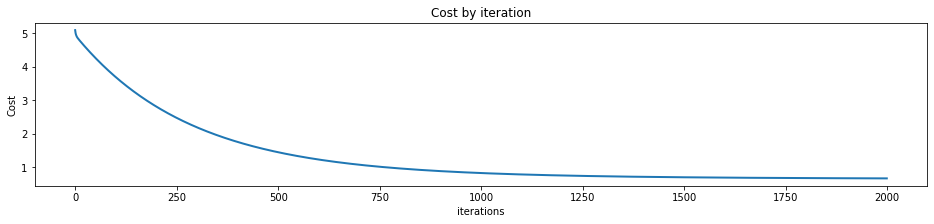

In [6]:
import random

# grab our data
X, y = data, labels

# always a good idea to normalize
X = X / np.amax(X, axis=0)
y = y / np.amax(y, axis=0)

# choose a random initial m, b
w, b = [random.random(), random.random()], random.random()

# our function w1 * x1 + w2 * x2 + b
def F(X, w, b):
    return np.sum(w*X, axis=1) + b

# what is our error?
y_pred = F(X, w, b)
init_cost = cost(y_pred, y)

print("initial parameters: w1=%0.3f, w2=%0.3f, b=%0.3f"%(w[0], w[1], b))
print("initial cost = %0.3f" % init_cost)

# implement partial derivatives of our parameters
def dJdw1(X, y, w, b):
    return -np.dot(X[:,0], y - F(X, w, b))

def dJdw2(X, y, w, b):
    return -np.dot(X[:,1], y - F(X, w, b))

def dJdb(X, y, w, b):
    return -np.sum(y - F(X, w, b))

# choose the alpha parameter and number of iterations
alpha = 0.001
n_iters = 2000

# run through gradient descent
errors = []
for i in range(n_iters):
    w[0] = w[0] - alpha * dJdw1(X, y, w, b)
    w[1] = w[1] - alpha * dJdw2(X, y, w, b)
    b = b - alpha * dJdb(X, y, w, b)
    y_pred = F(X, w, b)
    j = cost(y_pred, y)
    errors.append(j)
    
# plot the error
plt.figure(figsize=(16, 3))
plt.plot(range(n_iters), errors, linewidth=2)
plt.title("Cost by iteration")
plt.ylabel("Cost")
plt.xlabel("iterations")

# what is our final error rate
y_pred = F(X, w, b)
final_cost = cost(y_pred, y)

print("final parameters: w1=%0.3f, w2=%0.3f, b=%0.3f"%(w[0], w[1], b))
print("final cost = %0.3f" % final_cost)

A nice thing to do is to visualize our function. We can plot the prediction surface, $f(X)$ as a function of  $X=\left[x_1,x_2\right]$ within some range. We do that in the next cell:

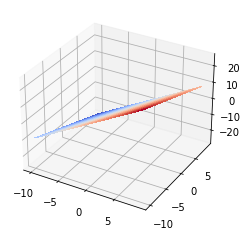

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
y = b + w[0]*x1 + w[1]*x2
ax.plot_surface(x1, x2, y, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)


We found a respectable cost applying linear regression to our dataset. But we can still do better. The problem with linear regression is the linearity. Sometimes, data is not so nicely shaped that a plane can fit it well. Real-world datasets are much more often irregularly shaped, with data being distributed along apparently curved surfaces. 

In order to give our function defined before, $F(X) = w_1*x_1 + w_2*x_2 + b$ more "flexibility," we can complicate it by introducing a non-linearity. One good non-linear transformation is a sigmoid function, which is given below.

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Let's implement the sigmoid function, and take a look at its graph.


Text(0.5, 1.0, 'Sigmoid function')

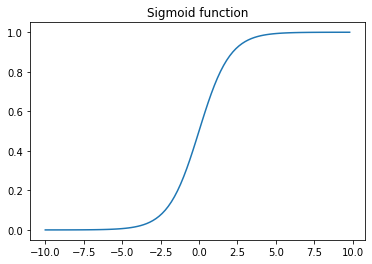

In [8]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

x = np.arange(-10.0, 10.0, 0.2)
sig = sigmoid(x)
plt.plot(x, sig)
plt.title('Sigmoid function')

Basically, a sigmoid just squashes any input it gets to between 0 and 1.

So we now modify our basic function in the following way: instead of just outputting the weighted sum by itself, $b + \sum w_i x_i$, we now pass that through the sigmoid function. 

In graphical terms, this looks like:

![2 input neuron sigmoid](https://ml4a.github.io/images/figures/neuron2sig.png)

So instead of $y = w_1 x_1 + w_2 x_2 + b$, our function now looks like:

$$
z = w_1 x_1 + w_2 x_2 + b \\
y = \sigma(z)
$$

Thus, the full equation is:

$$
y = \frac{1}{1 + e^{-(w_1 x_1 + w_2 x_2 + b)}} 
$$

But it's easier to imagine it as the two-step process we saw before.

Suppose we use the same parameters as before:

$$
w = \left[0.2, 0.6\right] \\
b = -0.3
$$

We can compute the predictions like so:

In [9]:
def weighted_sum(x, w, b):
    return b + np.dot(w, x)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# reset our parameters
w = [0.2, 0.6]
b = -0.3

X, y = data, labels

# get weighted sum like before
Z = [weighted_sum(x, w, b) for x in X]

# now transform the weighted sums with a sigmoid
y_pred = [sigmoid(z) for z in Z]

# evaluate error
error = cost(y_pred, y)
print(error)

829.3581552057615


That migh look much worse, but we haven't optimized yet!

Given the above weights, we can take a look at the graph of our neuron's activity.

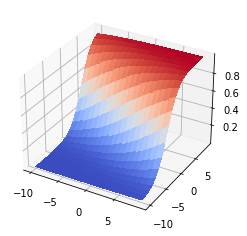

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
y = sigmoid(b + w[0]*x1 + w[1]*x2)
ax.plot_surface(x1, x2, y, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)


The function we posed above can already be considered a neural network. But let's complicate things a bit further, by adding a hidden layer. Neurons can be arranged in layers. So instead of having just two input neurons and an output neuron, let's place a layer of three neurons in the middle. 

Now it looks like this:

![2,3,1 net](https://ml4a.github.io/images/figures/neural_net_231.png)

It's important to realize that everything works as it did before. We start at the input layer on the left, and compute each middle neuron individually. Once they are calculated, we can perform the same operation for the output neuron and get the final result. We still have a function that takes in two inputs and outputs one final value. 

Note: it is typical to skip the non-linearity for the output layer. So we have sigmoids on the 3 middle layer neurons, but not the final output neuron.

Compared to our earlier linear regression, we have complicated things in two ways:
1) The addition of a non-linear sigmoid to each neuron's activation function (except for in the output neuron).
2) The addition of hidden layer in the middle.

The end result of this is our neural net is much more "flexible." It can bend and curve in various ways, depending on how the parameters are set. But it comes at a heavy cost: we can no longer do linear regression on it, and doing gradient descent on it will be more difficult, as we shall see.

Let's implement this in code. We now have two layers of weights. Let's call them $W1$ and $W2$. $W1$ has $2 \times 3$ connections, and $W2$ has $3 \times 1$ connections. We can create random initial weights with numpy.

In [11]:
W1 = np.random.randn(2, 3)
W2 = np.random.randn(3, 1)

print("W1=", W1)
print("W2=", W2)

W1= [[ 0.98457264 -0.92736384 -1.74857865]
 [-0.12929022 -1.6974088   0.63156962]]
W2= [[ 0.62819418]
 [ 0.97855301]
 [-0.66018897]]


For simplicity, let's just keep all the biases, $b$ fixed to 0 for now. We'll bring them back layer.

To do the full operation from the input layer to the output layer is called a "forward pass." The next cell will implement a forward pass.

In [12]:
X, y = data, labels

# first layer weighted sum z
z = np.dot(X, W1)

# project z through non-linear sigmoid
z = sigmoid(z)

# do another dot product at end (sigmoid is omitted)
y_pred = np.dot(z, W2)

# what is our cost
error = cost(y_pred, y)

print('predicted %0.2f for example 0, actual %0.2f, total cost %0.2f'%(pred_y[0], y[0], error))

predicted 2.92 for example 0, actual 6.70, total cost 145331.77


Let's turn this basic operation into We can turn this into a class.

In [13]:

class Neural_Network(object):
    def __init__(self, n0, n1, n2):        
        self.n0 = n0
        self.n1 = n1
        self.n2 = n2
        
        # initialize weights
        self.W1 = np.random.randn(self.n0, self.n1)
        self.W2 = np.random.randn(self.n1 ,self.n2)
        
    def predict(self, x):
        z = np.dot(x, self.W1)
        z = sigmoid(z)
        y = np.dot(z, self.W2)
        return y
  

Instantiate a neural network with 2 input neurons, 3 hidden neurons, and 1 output neuron.

In [14]:
net = Neural_Network(2, 3, 1)    

Now to do a forward pass, we can simply run the networks `predict` function:

In [15]:
X, y = data, labels
y_pred = net.predict(X)
error = cost(y_pred, y)

print('predicted %0.2f for example 0, actual %0.2f, total cost %0.2f'%(pred_y[0], y[0], error))

predicted 2.92 for example 0, actual 6.70, total cost 176144.27


## Gradient descent

To review, we have a 2x3x1 neural network with 9 weights and 4 biases for 13 total parameters. How can we optimize the parameters to minimize our cost function.

As with our linear regression example from before, we know we can solve it with gradient descent. Actually, now we *have* to solve it with gradient descent! Linear regression could actually be solved analytically, but for neural networks, no analytical solution can be used to find the parameters, since it is non-linear.

So how will gradient descent work here? Recall that the goal of gradient descent is to find the gradient of the loss function $J$ with respect to the parameters $w$ (note, we are including the biases in $w$).

$$\nabla J = \left[ \frac{\partial J}{\partial w_1}, \frac{\partial J}{\partial w_2}, ..., \frac{\partial J}{\partial w_n} \right]$$

So that we may be able to apply an iterative update rule to each of the parameters:

$$ w_i := w_i - \alpha \cdot \frac{\partial J}{\partial w_i} $$

Let's start with the simplest way of calculating the gradient, the numerical (experimental way). Recall that the definition of any derivative is:

$$f^\prime(x) = \lim_{\Delta x\to 0} \frac{f(x + \Delta x) - f(x)}{\Delta x} $$

Thus, the partial derivative of the loss with respect to any weight can be calculated as:

$$ \frac{\partial J}{\partial w_i} = \lim_{\Delta w_i \to 0} \frac{J(w_i + \Delta w_i) - J(w_i)}{\Delta w_i} $$

This provides us a very simple, straightforward way to get the gradient. We just pick some small $\Delta w_i$ and then for each weight, compute the value of the loss at the current $w_i$ and at $w_i+\Delta w_i$, and take the difference.

Note that while this method is very simple, it is also very slow and computationally inefficient. That's because it requires doing a forward pass of the network for every single parameter, for *each* update. At 13 weights, that's no big deal, but if our network has 1,000,000 weights, that's at least 1,000,000 forward passes, each of which have at least 1,000,000 multiplications. We shall see later that there exists a fast and efficient way of computing the gradient, called _Backpropagation_. But for now, we will use the slow way because it is much easier to understand and implement. 


In the next cell, we implement the numerical method for calculating the gradient, given a network and dataset.

In [16]:
import itertools

def get_gradient(net, X, y):
    w_delta = 1e-8

    # get the current value of the loss, wherever the parameters are
    y_pred_current = net.predict(X)
    error_current = cost(y_pred_current, y)

    # grab the current weights and copy them (so we can restore them after modification)
    dw1, dw2 = np.zeros((net.n0, net.n1)), np.zeros((net.n1, net.n2))
    W1, W2 = np.copy(net.W1), np.copy(net.W2) 
    
    # for the first layer, iterate through each weight, 
    # perturb it slightly, and calculate the numerical 
    # slope between that loss and the original loss
    for i, j in itertools.product(range(net.n0), range(net.n1)):
        net.W1 = np.copy(W1)
        net.W1[i][j] += w_delta
        y_pred = net.predict(X)
        error = cost(y_pred, y)
        dw1[i][j] = (error - error_current) / w_delta

    # do the same thing for the second layer
    for i, j in itertools.product(range(net.n1), range(net.n2)):
        net.W2 = np.copy(W2)
        net.W2[i][j] += w_delta
        y_pred = net.predict(X)
        error = cost(y_pred, y)
        dw2[i][j] = (error - error_current) / w_delta

    # restore the original weights
    net.W1, net.W2 = np.copy(W1), np.copy(W2)

    return dw1, dw2


The above function `get_gradient` calculates the gradient of a 2-layer network `net`, given a dataset `X`, `y`. In the next cell, we now go through the learning procedure. We load our dataset, instantiate a neural network, and train it on the data using the gradient method made above.

initial cost = 57.672
final cost = 0.573


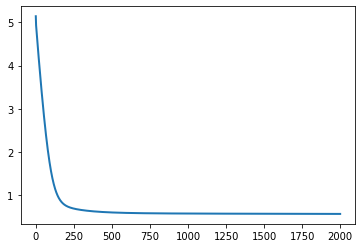

In [23]:
# load the data and labels
X, y = data, labels.reshape((len(labels),1))

# it's always a good idea to normalize the data between 0 and 1
X = X/np.amax(X, axis=0)
y = y/np.amax(y, axis=0)

# create a 2x3x1 neural net
net = Neural_Network(2, 3, 1)    

# what is the current cost?
y_orig = net.predict(X)
init_cost = cost(y_orig, y)
print("initial cost = %0.3f" % init_cost)

# Set the learning rate, and how many epochs (updates) to try
n_epochs = 2000
learning_rate = 0.01

# for each epoch, calculate the gradient, then subtract it from the parameters, and save the cost
errors = []
for i in range(n_epochs):
    dw1, dw2 = get_gradient(net, X, y)
    net.W1 = net.W1 - learning_rate * dw1
    net.W2 = net.W2 - learning_rate * dw2
    y_pred = net.predict(X)
    error = cost(y_pred, y)
    errors.append(error)
        
# plot it
plt.plot(range(0, len(errors)), errors, linewidth=2)

# what is the final cost?
y_pred = net.predict(X)
final_cost = cost(y_pred, y)
print("final cost = %0.3f" % final_cost)


So we have implemented a neural network with manual numerical gradient computation for gradient descent and used it to optimize a small network.

In the next guide, we are going to use [Keras](http://www.keras.io), a high-level machine learning library which we will use throughout the class from this point forward.